## 1. Import Libraries 

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix

## 2. Load processed dataset

In [87]:
data = pd.read_csv('news_data.csv')
data.head()

,Headline,Introduction,Body,Category
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,"The firm, which is now one of the biggest inve...",business
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,And Alan Greenspan highlighted the US governme...,business
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,State-owned Rosneft bought the Yugansk unit fo...,business
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,Reporting its results for the three months to ...,business
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,Reports in the Wall Street Journal and the Fin...,business


## 3. Prepare and Pre-process the data 

> 1. For the testing, the body part of the news is considered along with target categories.
> 2. All the text in the dataset will converted to lower case to keep the same meaning for similar words
> 3. Then each record in the set will be tokenized for further process

In [98]:
# Make a copy of dataset
df=data[['Body','Category']].copy()
# get a list target classes
targets=df.Category.unique().tolist()
# Convert text in the each columns to lowercase
df = df.astype(str).apply(lambda x: x.str.lower())
# Tokenization : In this each entry in the dataset will be broken into set of words
df['processed']= [word_tokenize(entry) for entry in df['Body']]
df.head()

,Body,Category,processed
0,"the firm, which is now one of the biggest inve...",business,"[the, firm, ,, which, is, now, one, of, the, b..."
1,and alan greenspan highlighted the us governme...,business,"[and, alan, greenspan, highlighted, the, us, g..."
2,state-owned rosneft bought the yugansk unit fo...,business,"[state-owned, rosneft, bought, the, yugansk, u..."
3,reporting its results for the three months to ...,business,"[reporting, its, results, for, the, three, mon..."
4,reports in the wall street journal and the fin...,business,"[reports, in, the, wall, street, journal, and,..."


> 4. As the next step, All the stop words such as "the”, “is”, “in”, “for” etc will be removed along with non alphabetic words.
> 5. Then the Lemmatization process will applied on each token.

In [99]:
# Remove Stop words, Non-Numeric and perfom Word Lemmenting.
col = 'processed'
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,text in enumerate(df[col]):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(text):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    df.loc[index,'processed'] = str(Final_words)
df.head()

,Body,Category,processed
0,"the firm, which is now one of the biggest inve...",business,"['firm', 'one', 'big', 'investor', 'google', '..."
1,and alan greenspan highlighted the us governme...,business,"['alan', 'greenspan', 'highlight', 'u', 'gover..."
2,state-owned rosneft bought the yugansk unit fo...,business,"['rosneft', 'buy', 'yugansk', 'unit', 'sale', ..."
3,reporting its results for the three months to ...,business,"['report', 'result', 'three', 'month', 'decemb..."
4,reports in the wall street journal and the fin...,business,"['report', 'wall', 'street', 'journal', 'finan..."


> 6. The whole dataset will be splitted in to train and test set based on the catgeories. Instead of splitting the dataset in a random manner, fixed proportion of each category are taken for the test-train split. Here 80% of each class are taken for the training set

In [100]:
# Split dataset into train and split
train_df = pd.DataFrame()
test_df = pd.DataFrame()

for label in df.Category.unique().tolist():
    train_split=df[df.Category==label].sample(frac=0.80)
    test_split=df[df.Category==label].drop(train_split.index)
    train_df = train_df.append(train_split)
    test_df = test_df.append(test_split) 
    
train_x,train_y = train_df.iloc[:,2],train_df.iloc[:,1]
test_x,test_y = test_df.iloc[:,2],test_df.iloc[:,1]
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(1781,) (1781,) (444,) (444,)


> 7. Target columns of both sets will be encoded. ie, each class will be replaaced with numeric values like 0,1,2,3,4.

In [101]:
# Encoding
Encoder = LabelEncoder()
train_y = Encoder.fit_transform(train_y)
test_y = Encoder.fit_transform(test_y)
print(train_y.shape,test_y.shape)

(1781,) (444,)


> 8. As final step, the processed words will be further vectorized for the prediction algorithms.

In [102]:
# Word Vectorization
Tfidf_vect = TfidfVectorizer(min_df=5, norm='l2',ngram_range=(1, 2),)
Tfidf_vect.fit(df[col])
Train_X_Tfidf = Tfidf_vect.transform(train_x)
Test_X_Tfidf = Tfidf_vect.transform(test_x)
print(Train_X_Tfidf.shape,Test_X_Tfidf.shape)

(1781, 4238) (444, 4238)


## 4. Use the ML Algorithms to Predict the outcome

> Since the data is available in the labelled format, The type models chosen here are supervised machine learning algorithms. The different classification models given below are used for the comparison.
>> - In order to analyse the model performance, four different matrics such as Accuracy, precission, recall and f1-score are taken along with the confusion matrix.
>> - The train and test split taken are same for all the three models
>> - 1899 samples are taken for the training set and 334 samples are taken for the testing

#### 1. Naive Bayes Algorithm

<---Naive Bayes--->
Accuracy : 95.27027027027027
Precision: 0.953
Recall: 0.951
f1_Score: 0.952


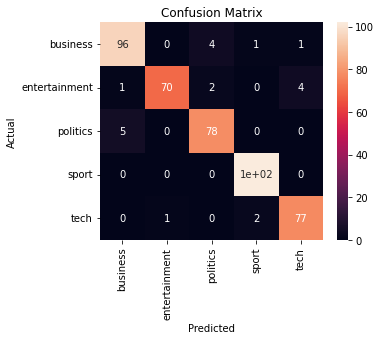

In [103]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,train_y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)


# calculate accuracy_score
print("<---Naive Bayes--->\nAccuracy :",accuracy_score(predictions_NB, test_y)*100)
# calculate precission
precision_NB = precision_score(test_y, predictions_NB, average='macro')
print('Precision: %.3f' % precision_NB)
# calculate recall
recall_NB = recall_score(test_y, predictions_NB, average='macro')
print('Recall: %.3f' % recall_NB)
# calculate f1-score
f1_Score_NB =  (2 * precision_NB * recall_NB) / (precision_NB + recall_NB)
print('f1_Score: %.3f' % f1_Score_NB)

# Generate Confusion Matrix
cm= confusion_matrix(test_y, predictions_NB)
cm_df = pd.DataFrame(cm,index = targets, columns = targets)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 2. Support Vector Machine

SVM Accuracy Score ->  95.04504504504504
Precision: 0.950
Recall: 0.950
f1_Score: 0.950


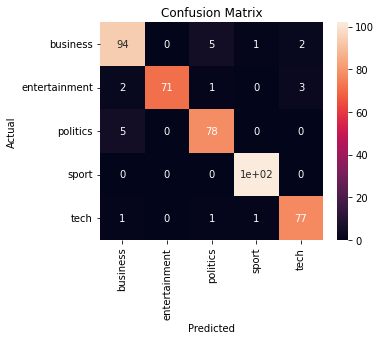

In [126]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=5, gamma='auto')
SVM.fit(Train_X_Tfidf,train_y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# calculate accuracy_score
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_y)*100)
# calculate precission
precision_svm = precision_score(test_y, predictions_SVM, average='micro')
print('Precision: %.3f' % precision_svm)
# calculate recall
recall_svm = recall_score(test_y, predictions_SVM, average='micro')
print('Recall: %.3f' % recall_svm)
# calculate f1-score
f1_Score_svm =  (2 * precision_svm * recall_svm) / (precision_svm + recall_svm)
print('f1_Score: %.3f' % f1_Score_svm)

# Generate Confusion Matrix
cm= confusion_matrix(test_y, predictions_SVM)
cm_df = pd.DataFrame(cm,index = targets, columns = targets)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 3. Random Forest Classification

Random Forest Accuracy Score ->  90.76576576576578
Precision: 0.908
Recall: 0.908
f1_Score: 0.908


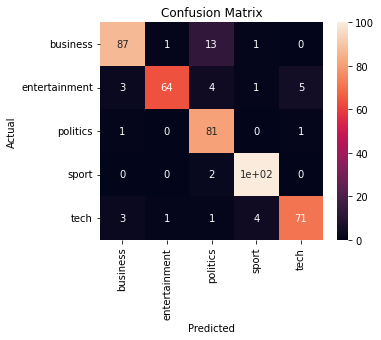

In [106]:
RF= RandomForestClassifier(n_estimators= 250,max_features="auto",min_samples_leaf=1)  
RF.fit(Train_X_Tfidf,train_y)  
predictions_RF = RF.predict(Test_X_Tfidf)

# calculate accuracy_score
print("Random Forest Accuracy Score -> ",accuracy_score(predictions_RF, test_y)*100)
# calculate precission
precision_RF = precision_score(test_y, predictions_RF, average='micro')
print('Precision: %.3f' % precision_RF)
# calculate recall
recall_RF = recall_score(test_y, predictions_RF, average='micro')
print('Recall: %.3f' % recall_RF)
# calculate f1-score
f1_Score_RF =  (2 * precision_RF * recall_RF) / (precision_RF + recall_RF)
print('f1_Score: %.3f' % f1_Score_RF)

# Generate Confusion Matrix
cm= confusion_matrix(test_y, predictions_RF)
cm_df = pd.DataFrame(cm,index = targets, columns = targets)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Performance Comparisson

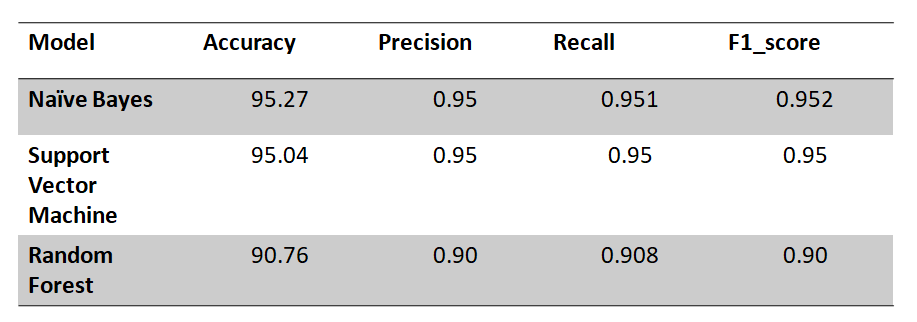

>- Here the Naive Bayes and the Support vector machine model performs better compares to random forest model.
>- As part of Model improvement, parameter tuning can be applied.
>- As further steps, the Deep learning models can also be utilised.

- But when the model is trained with the 'Introduction' column (instead of body), The metrics are varied. We can observe a significant drop in performance. Please see the table given below. 

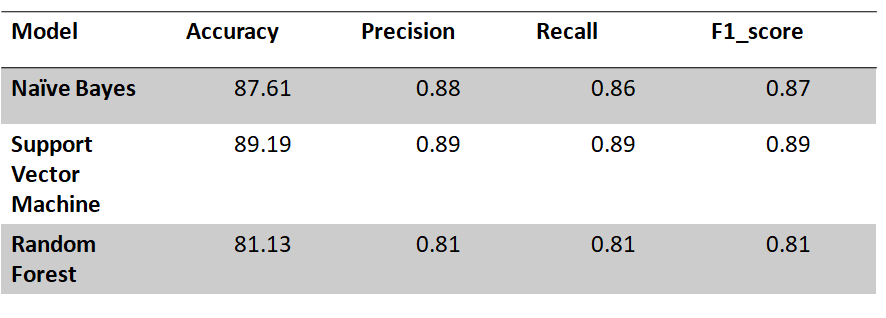